# Load libraries

In [1]:
import os
import json
from pathlib import Path

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors

for dirname, _, filenames in os.walk('arc'):
    print(dirname)

arc
arc/evaluation
arc/test
arc/training


# Load data

In [4]:
from data import training_path
from data import training_tasks, evaluation_tasks, test_tasks

# Load plot utils

In [39]:
from plot_utils import cmap, norm
from plot_utils import nth_sample
from plot_utils import load_and_plot, plot_one_ax
from plot_utils import plot_task, plot_pred_and_target, plot_task_and_pred, just_plot

# Load DSL

In [5]:
from dsl import (
    # Task 126, 35, 38
    crop_to_content_unlifted,
    # Task 35
    group_by_color_unlifted,
    negative_by_max_color_unlifted,
    negative_by_most_frequent_color_unlifted
)

In [8]:
# Task 216, 56
from dsl import fractal_repetition
# Task 176
from dsl import reflect_image

In [ ]:
# Task 117, 30
from dsl import crop_unique_colors_orthogonal_to_color_continuity
# Or
from dsl import (
    select_row, select_col, unique_rows, unique_cols, reshape_to_row, reshape_to_col
)

In [ ]:
# Task 134, 38
from dsl import find_rectangle, retrieve_quadrants

In [ ]:
# Task 204
from dsl import draw_straight_lines_from_seeds, find_rectangle_by_entropy, match_coords

In [ ]:
# Tried in task 110
from dsl import infect, normalize_color_by_dominant

In [16]:
# Task 28
from dsl import filter_by_corners, extract_closure_from_rect

In [ ]:
# Task 232
from dsl import match_and_fit_patterns

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
print(len(training_tasks), len(evaluation_tasks), len(test_tasks))

400 400 100


## Solving manually all tasks with the 'crop' pattern (and some others)

### Insights

- Break solutions in composable functions. For example, the solution to Task 746b3537.
  - The idea is to select the row or the column based in the color homogeinity.
  - I solved directly, but the solution could be composed of functions or be constructed by trial and error. Look there for insightful comments.
  - See the new solution there.

# Just crop

## Task 30 [1cf80156]

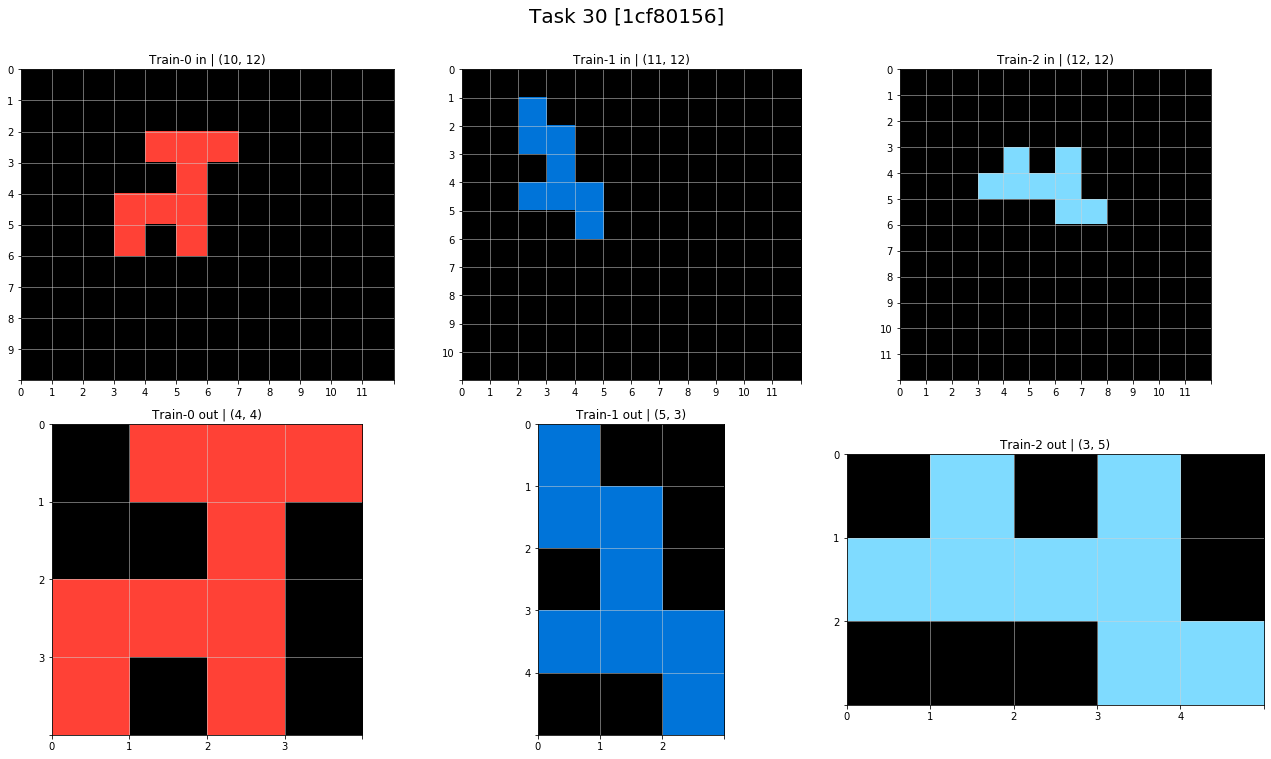

In [149]:
fname = '1cf80156.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, only_train=True)

In [150]:
task = task_dict['test']

In [151]:
sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)

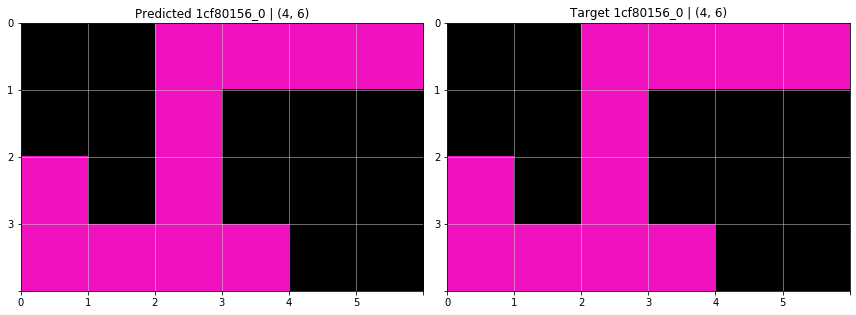

In [152]:
pred = crop_to_content_unlifted(pixmap_in)
plot_pred_and_target(pred, pixmap_out, fname, sample_id)

# Pattern repetition 

## Fractal repetition

### Task 216 [8f2ea7aa]

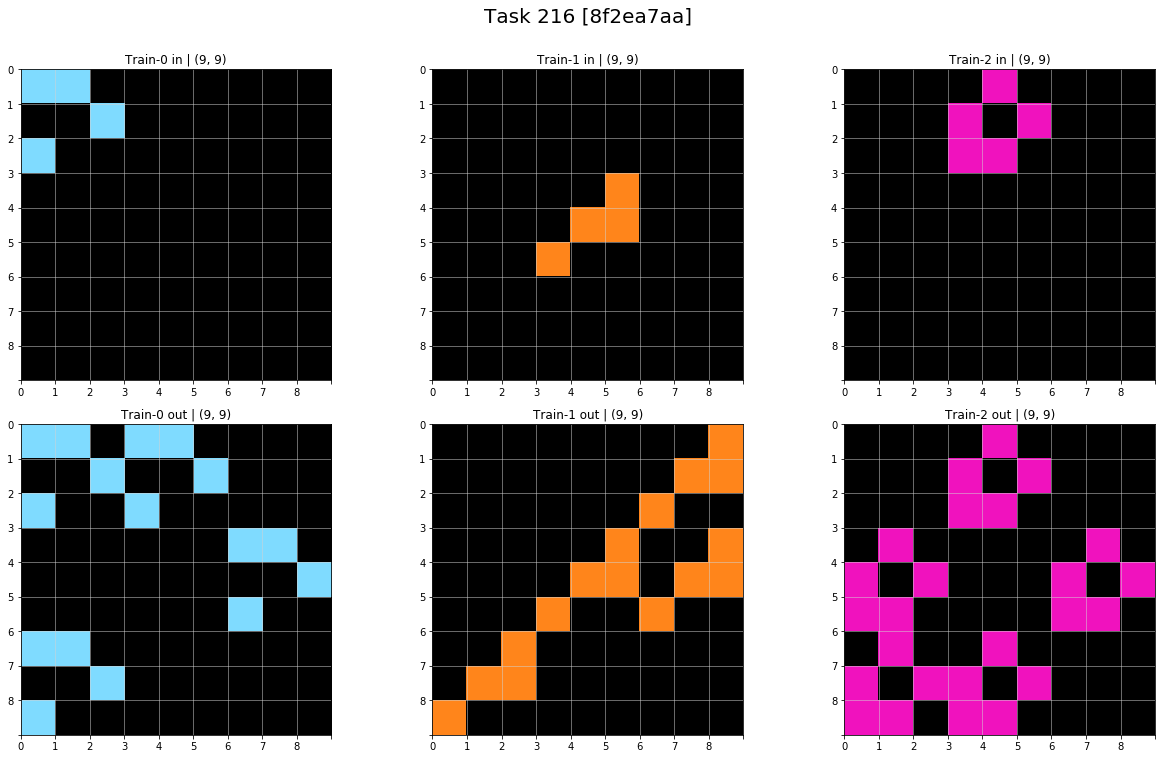

In [153]:
fname = '8f2ea7aa.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, only_train=True)

In [154]:
task = task_dict['test']

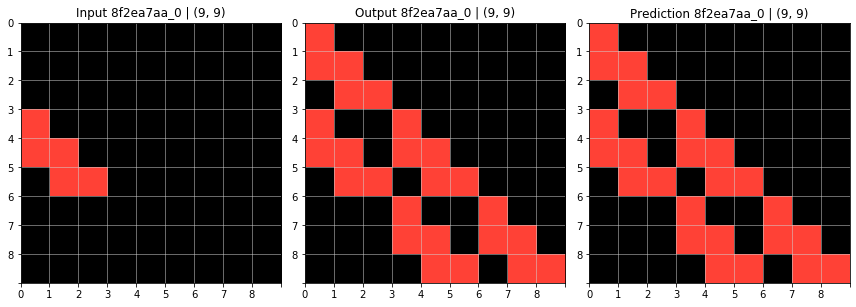

In [155]:
sample_id = 0
pixmap_in = np.array(task[sample_id]['input'])
pred = fractal_repetition(pixmap_in)
plot_task_and_pred(task, pred, fname, sample_id)

## Normal repetition

### Task 56 [28bf18c6 ] [incomplete]

- Patterns: crop, pattern repetition.

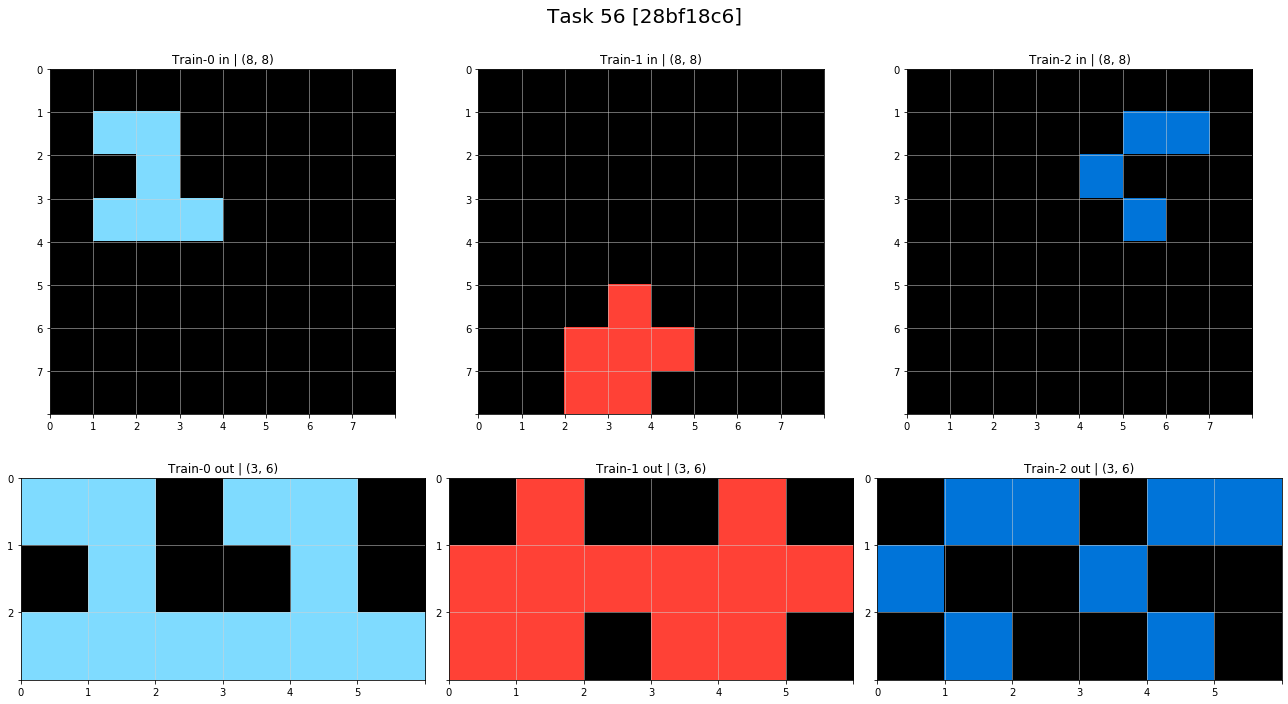

In [156]:
fname = '28bf18c6.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, only_train=True)

In [157]:
task = task_dict['test']

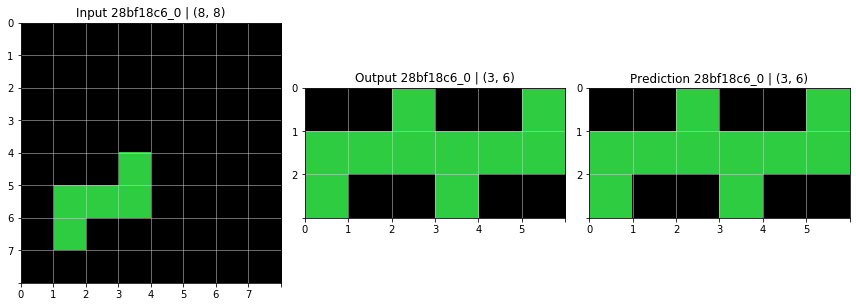

In [158]:
from dsl import pattern_repetition

for sample_id in range(len(task)):
    pixmap_in, pixmap_out = nth_sample(task, sample_id)
    pred = pattern_repetition(pixmap_in)
    plot_task_and_pred(task, pred, fname, sample_id)

# Image reflection

## Task 176 [7468f01a]

- Crop then reflect.

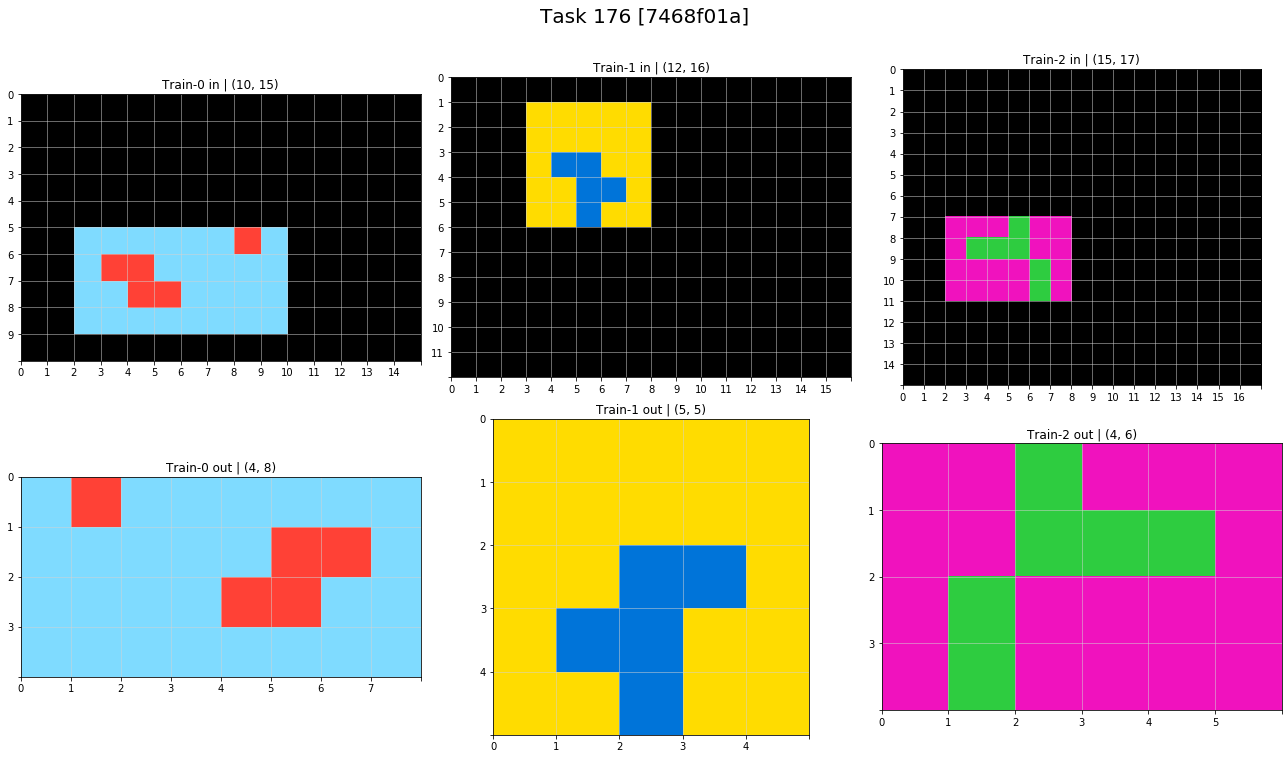

In [159]:
fname = '7468f01a.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, only_train=True)

In [160]:
task = task_dict['test']

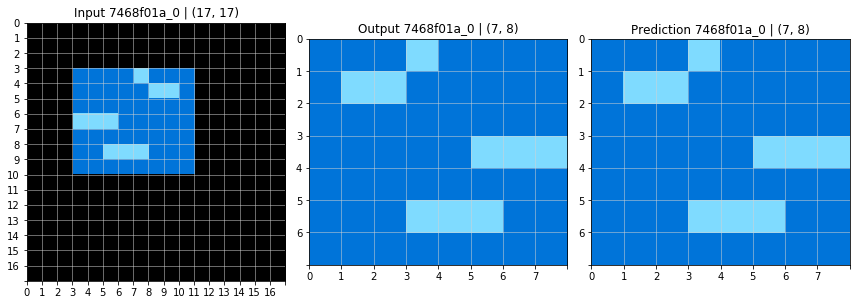

In [161]:
from dsl import reflect_image, crop_to_content_unlifted

sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = reflect_image(crop_to_content_unlifted(pixmap_in))
plot_task_and_pred(task, pred, fname, sample_id)

# Guessing

## Direction guessing

### Task 117 [746b3537]

#### Insights

- Crop line orthogonal to color direction. For example Train-0 out is a vertical crop, because color direction is horizontal.
- Drop repeated *continguous* colors. 
- This crop pattern is different from previous regarding what is being selected:
  - Previously it was objects surrounded by 0-pixels.
  - In this case, it isn't an object per si (what *is* a object, really?), but its properties.
  - This is easy: if first row has unique colors, color direction is column-wise.

#### Solution

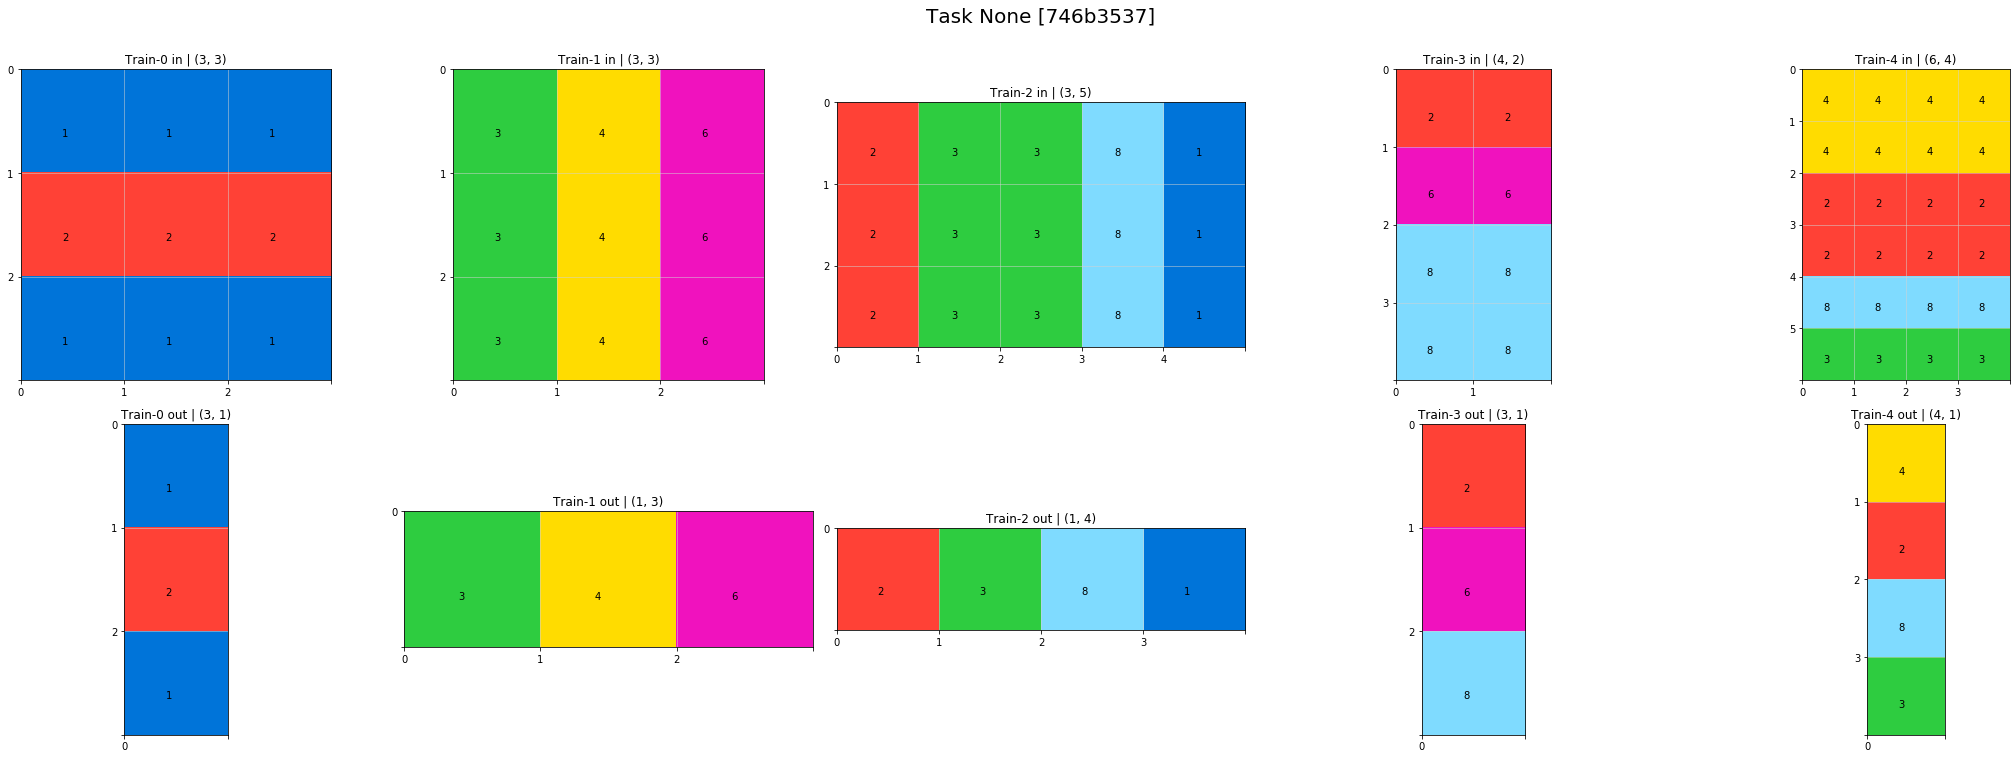

In [162]:
fname = '746b3537.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, annotate=True, only_train=True)

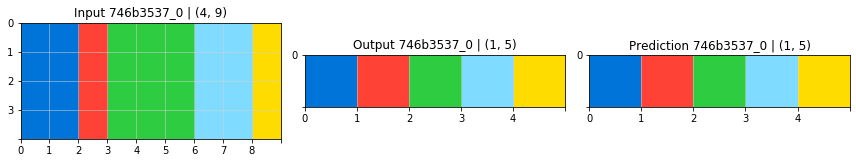

In [163]:
from dsl import crop_unique_colors_orthogonal_to_color_continuity

task = task_dict['test']
sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = crop_unique_colors_orthogonal_to_color_continuity(pixmap_in)
plot_task_and_pred(task, pred, fname, sample_id)

#### Solution with composable functions

- This is the idea. Learn how to compose solutions based on (input, output) pairs.

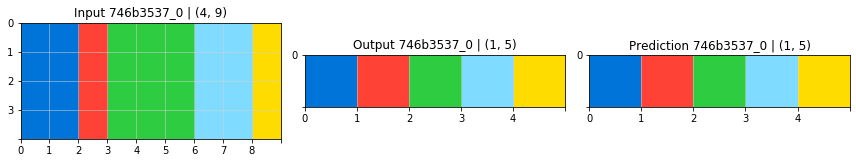

In [164]:
from dsl import reshape_to_col, unique_rows, select_col

task = task_dict['test']
sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = reshape_to_row(unique_cols(select_row(pixmap_in)))
plot_task_and_pred(task, pred, fname, sample_id)

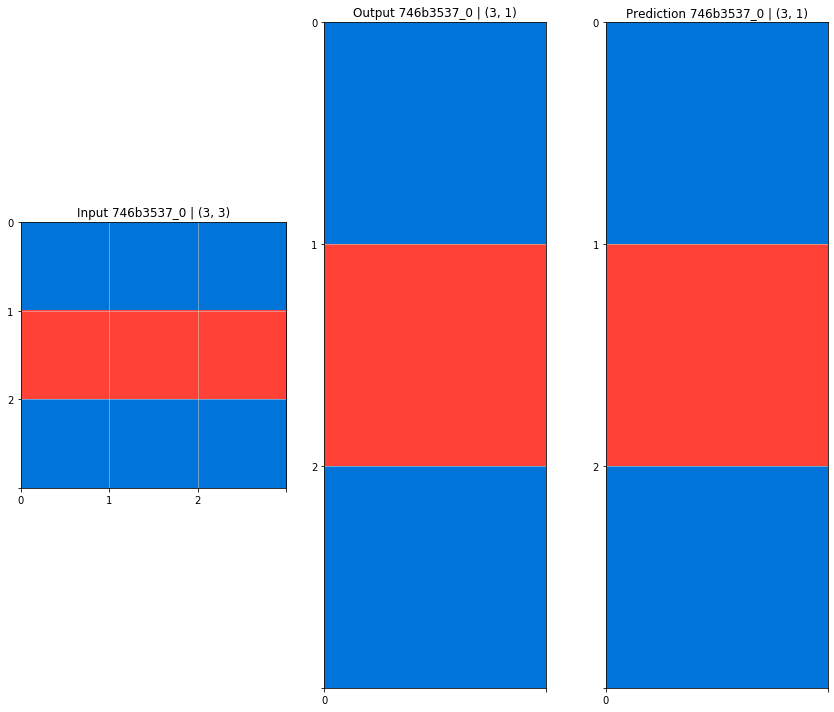

In [165]:
from dsl import reshape_to_row, unique_cols, select_row

task = task_dict['train']
sample_id = 0

pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = reshape_to_col(unique_rows(select_col(pixmap_in)))
plot_task_and_pred(task, pred, fname, sample_id)

## Rectangle guessing stable position

### Task 134 [partially solved; need learning] 

#### Insights

- Is it okay to use the input and output in the method?
  - For the traininig samples, sure. For evaluation and test? Nope. You need to learn the way, padawan.

#### Solution

- Aim to solve way similar to 4.1.1 Task 117

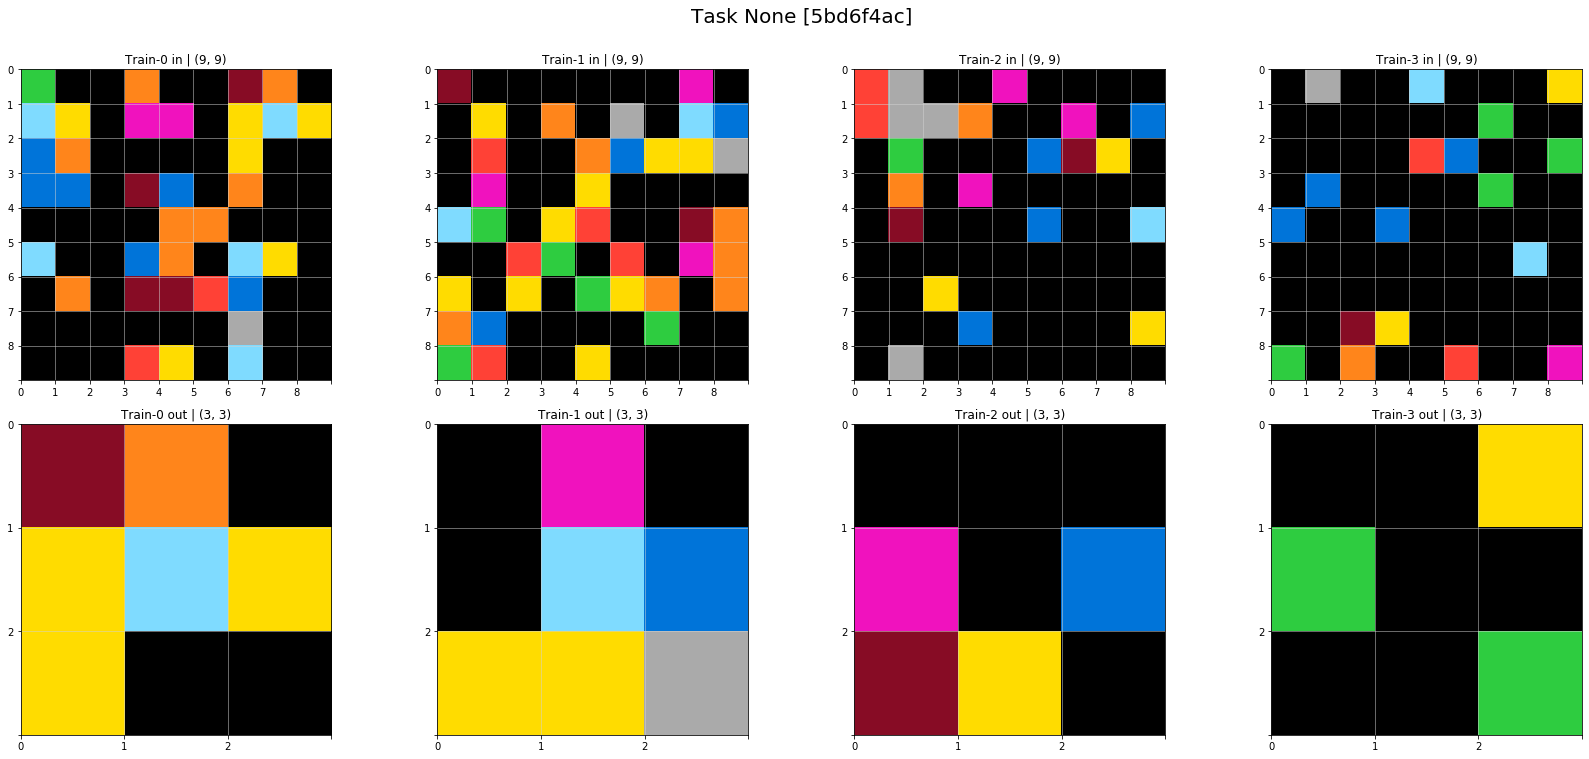

In [166]:
fname = '5bd6f4ac.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, only_train=True)

In [167]:
task = task_dict['train']

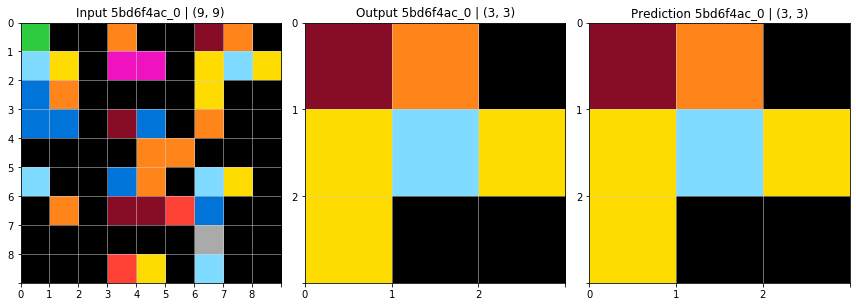

In [175]:
from dsl import find_rectangle

sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, 0)
pred = find_rectangle(pixmap_in, stride=3, position=2)  # stride and position can be changed
plot_task_and_pred(task, pred, fname, sample_id)

# Wrong because find_rectangle doesn't know which rectangle to retrieve.
# The solution must have a way to learn which position the rectangle is across the samples.

## Rectangle guessing unstable position

### Draw line from point

#### Task 204

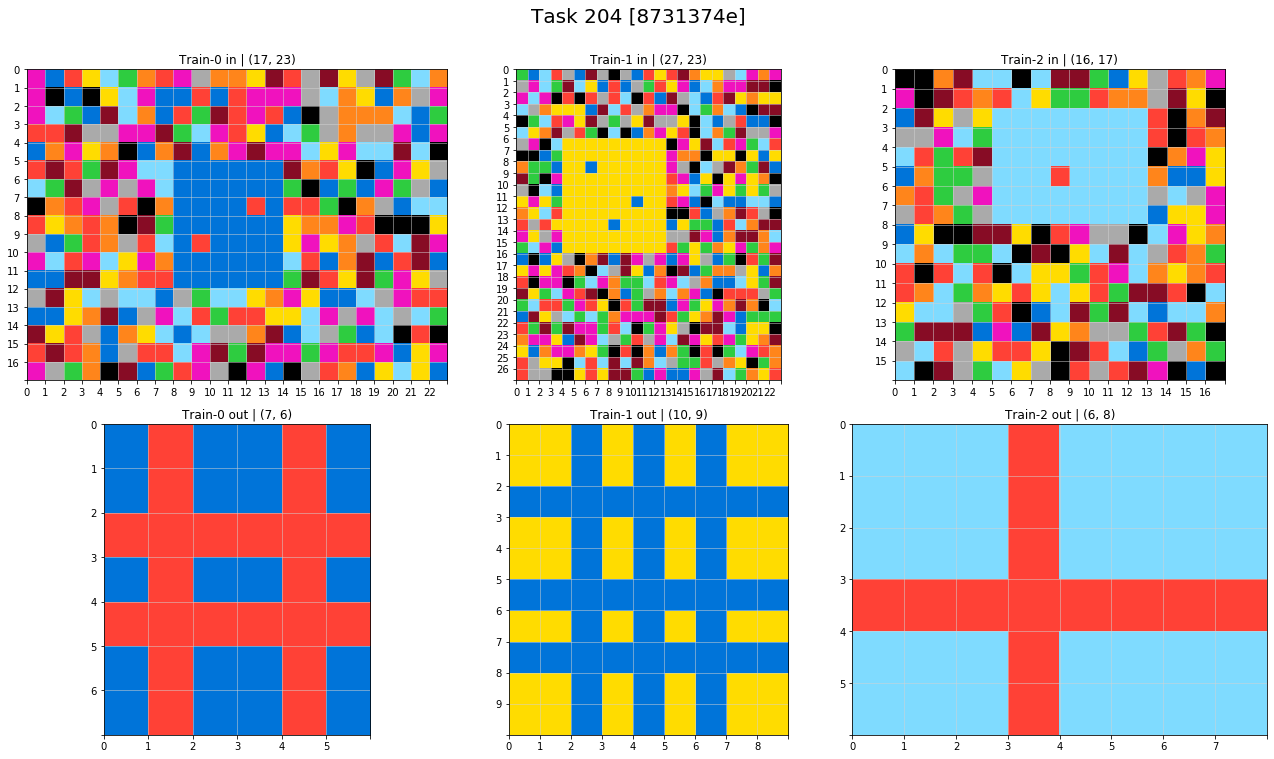

In [176]:
fname = '8731374e.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, only_train=True)

In [177]:
task = task_dict['test']

/home/lativ/.virtualenvs/dl/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


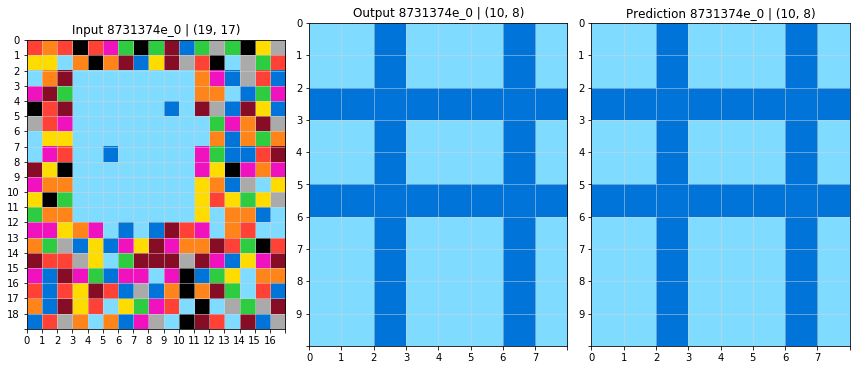

In [178]:
from dsl import find_rectangle_by_entropy, draw_straight_lines_from_seeds

sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = draw_straight_lines_from_seeds(find_rectangle_by_entropy(pixmap_in))
plot_task_and_pred(task, pred, fname, sample_id)

# Find the intruder

## Task 110 [48d8fb45]

- Aims: crop the *object* *infected* (?) by the intruder.
- Difficulty level: 5/10

### Insights

- Solution 1
    - Crop objects and select which has only two colors (foreground, background).
      - Crop by recursion:
        1. Select a random xy-position in the pixmap.
        2. Traces a vertical and a horizontal segments to split the pixmap in 4 subpixmaps, which including the segments.
           - Check if the segments intersect the objects. If there is at least...
    - Remove segment with intruder pixel.
- Solution 2
    - Infect and crop to content. But how dispose the intruder? Store its location.
    - Maybe cellular automata can be useful. In the kaggle there is a kernel trying to solve some problems with it.
- Solution 3 [works]
    - What is a intruder? I must answer this knowning that something must be learned across the samples.
    - This time I will filter the pixmap by the least common color.
    - Get intruder (pixel) position, then find *infected* object by intruder.
        - The object *infected* will be nearby.
        - The object shape is consistent across samples.

### Solution

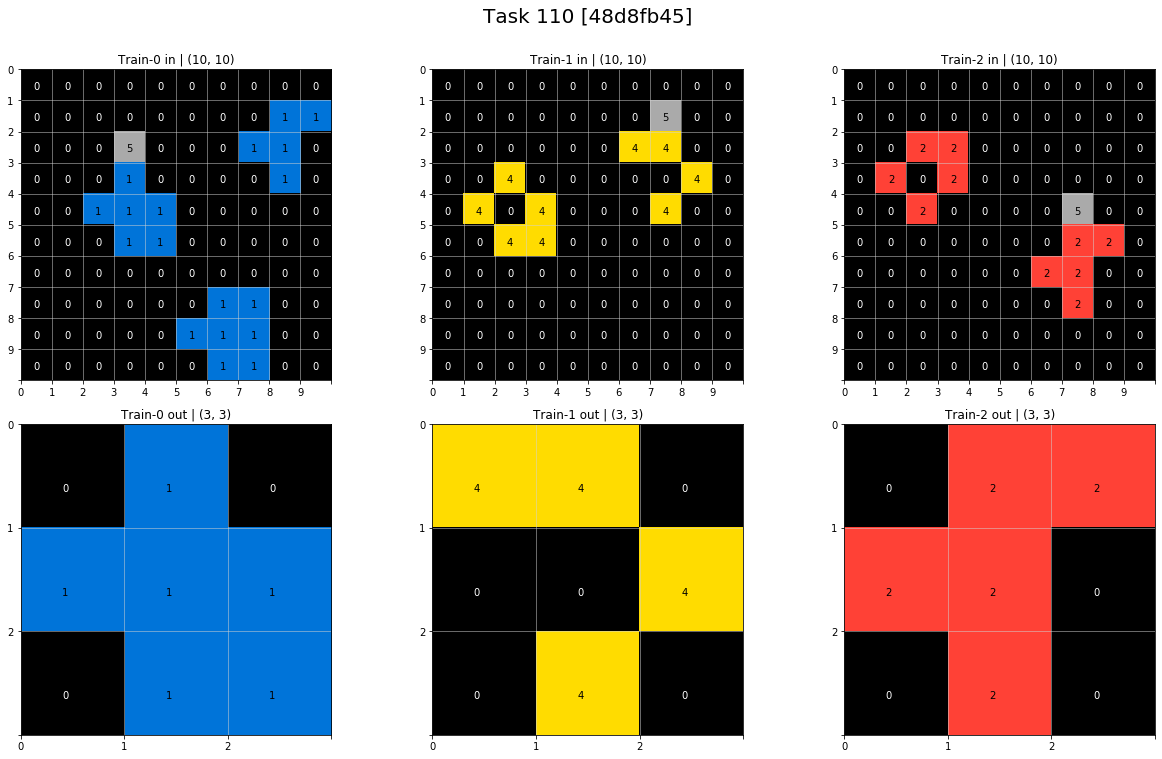

In [179]:
fname = '48d8fb45.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, annotate=True, task_id=tid, only_train=True)

In [233]:
task = task_dict['test']

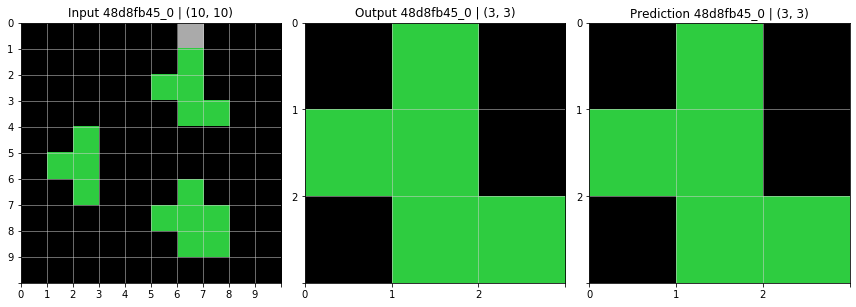

In [234]:
from dsl import detect_infected_object

sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = detect_infected_object(pixmap_in)
plot_task_and_pred(task, pred, fname, sample_id)

## Task 35 [partially solved; need learning]

- Patterns: crop, find the intruder.
- Aims: crop the non-intruder *object*.

### Insights

- Group by color, crop by content.
  - Assumptions: intruders has different colors from the target object.

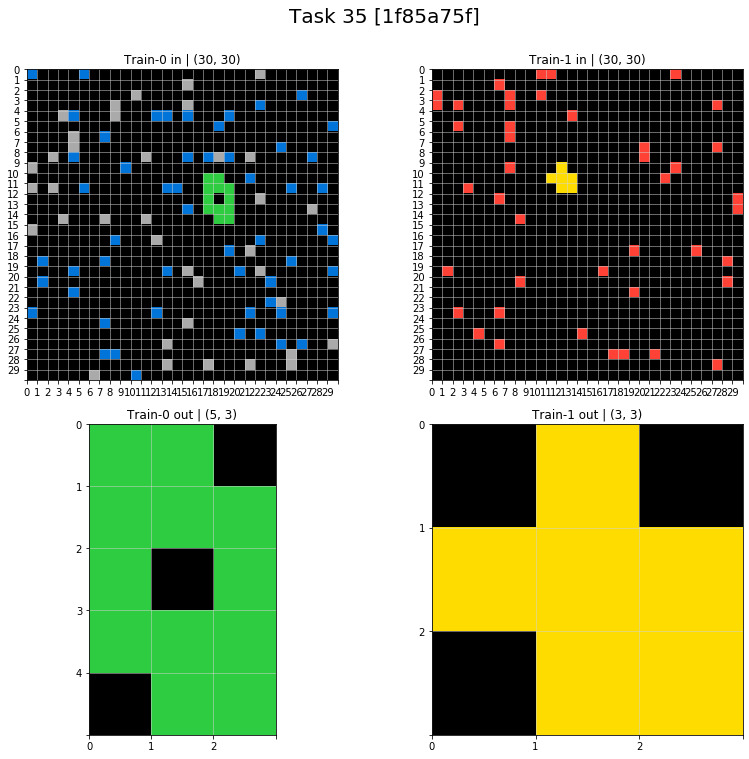

In [238]:
fname = '1f85a75f.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, only_train=True)

In [237]:
task = task_dict['test']

In [1145]:
from dsl import group_by_color_unlifted, crop_to_content_unlifted

sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
groups = group_by_color_unlifted(pixmap_in)
pred = crop_to_content_unlifted(groups[-2])  # can't know; need learning
plot_pred_and_target(task, pred, fname, sample_id)

# Deconstruction

## Task 38 [partialy solved; need learning]

- Patterns: crop, pattern_deconstruction.

### Solution

- Solution 1
    - Crop to content, then guess rectangle.
- Solution 2
    - Crop to content, then break in four parts. The solution must be learned.

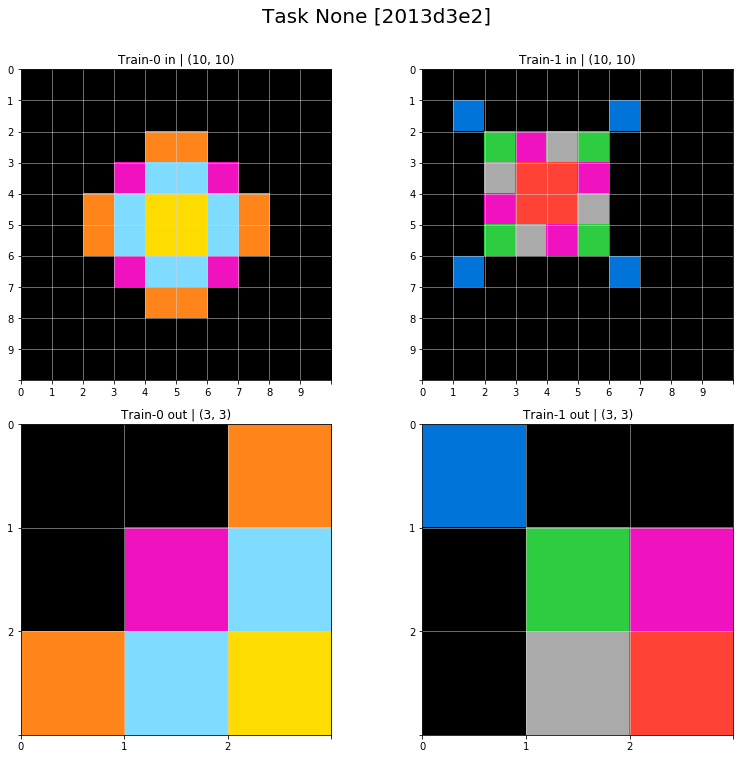

In [131]:
fname = '2013d3e2.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2, only_train=True)

In [132]:
task = task['train']

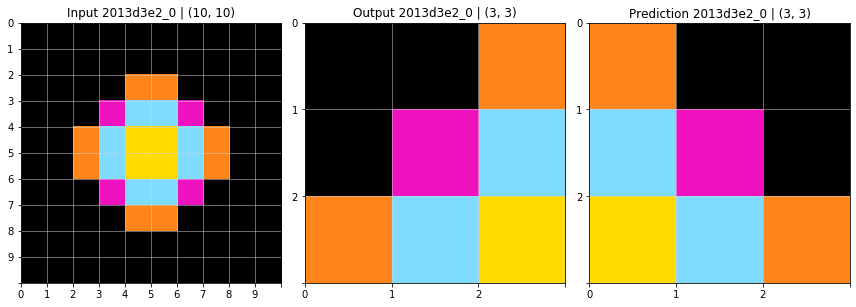

In [136]:
from dsl import crop_to_content_unlifted, find_rectangle

sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, 0)
pred = find_rectangle(crop_to_content_unlifted(pixmap_in), stride=3)
plot_task_and_pred(task, pred, fname, sample_id)

# Wrong because retrieve_quadrants doesn't know which quadrant to retrieve.
# The solution must have a way to learn which position the quandrant is across the samples.

# Enclosure

## Task 28 [1c786137] [partially solved]

- Patterns: crop, detect_enclosure.
- Solution: `filter_by_corners` => `extract_closure_from_rect`.
  - In `filter...` I use `group_by_color`.
- Need learning to select group.

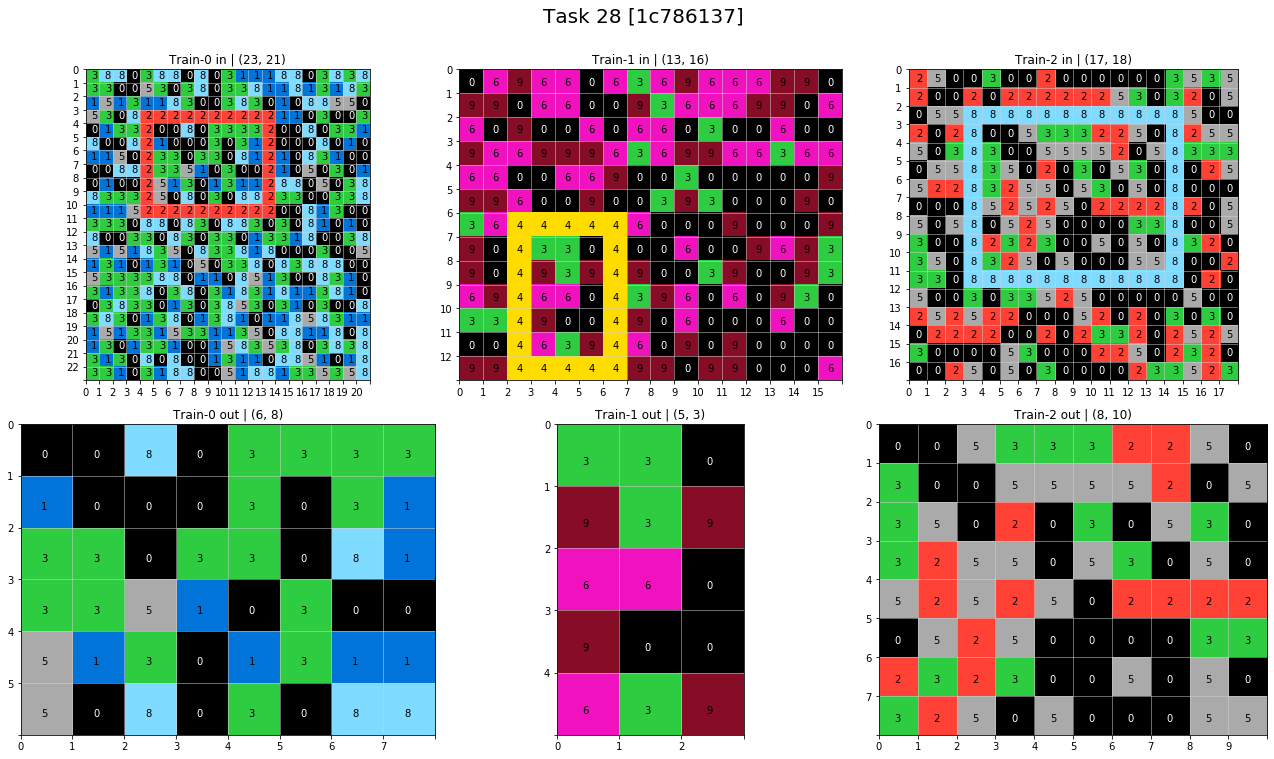

In [241]:
fname = '1c786137.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, annotate=True, only_train=True)

In [256]:
task = task_dict['test']

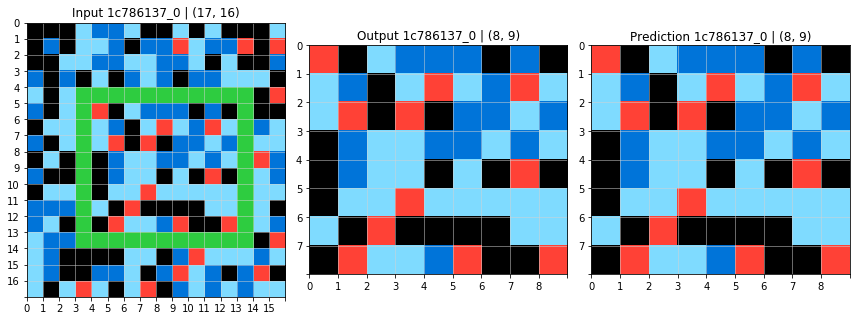

In [271]:
from dsl import extract_closure_from_rect

sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = extract_closure_from_rect(pixmap_in)
plot_task_and_pred(task, pred, fname, sample_id)

# Jigsaw Puzzle

## Pattern juxtaposition / transform / moving 

### Task 232 

- Difficulty: 8/10
- Need a *better* solution.

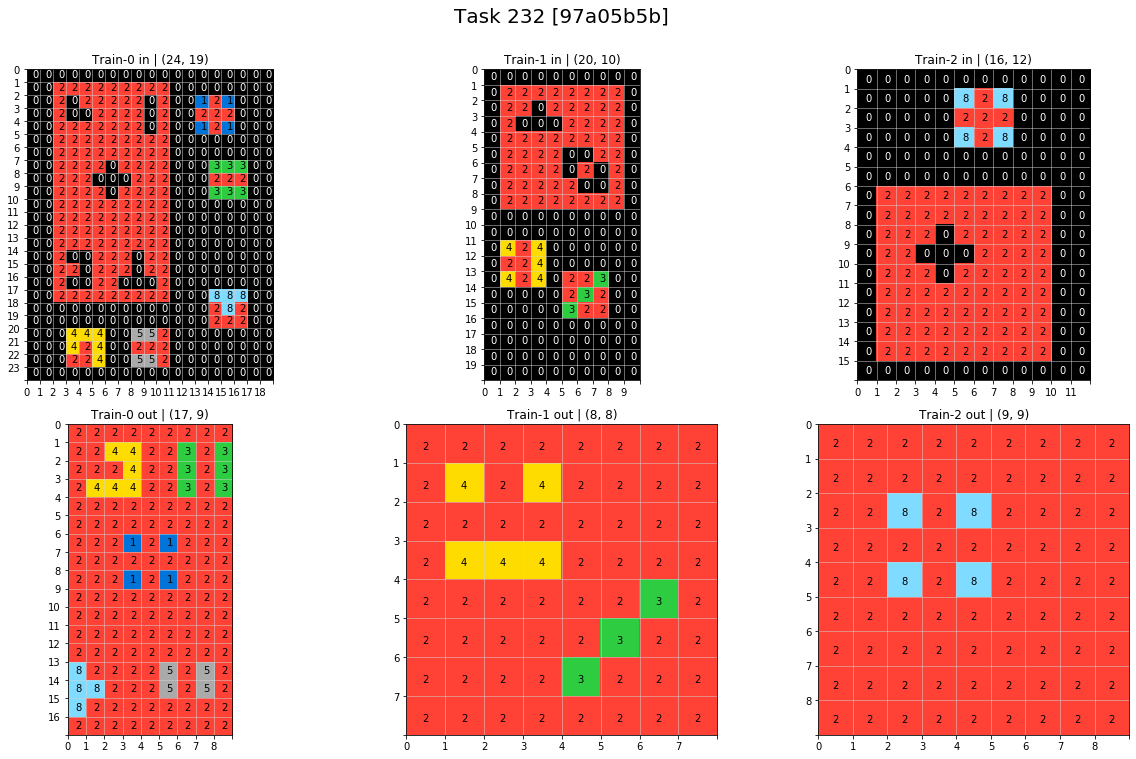

In [137]:
fname = '97a05b5b.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, annotate=True, only_train=True)

In [138]:
task = task_dict['test']

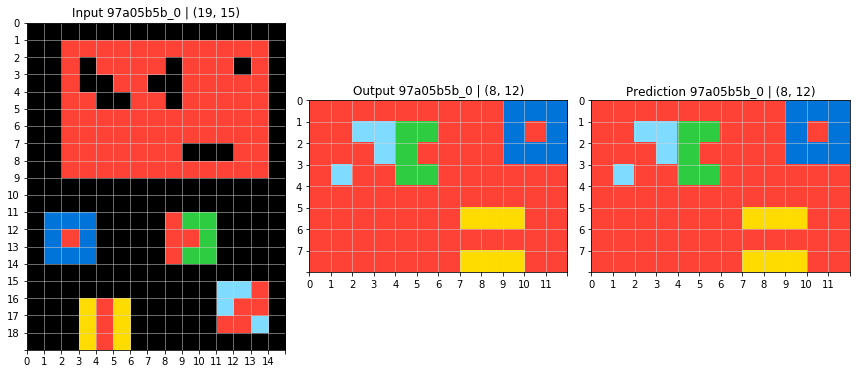

In [142]:
from dsl import match_and_fit_patterns

for sample_id in range(len(task)):
    pixmap_in, pixmap_out = nth_sample(task, sample_id)
    pred = match_and_fit_patterns(pixmap_in)
    plot_task_and_pred(task, pred, fname, sample_id)